In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

import albumentations as A
import segmentation_models as sm
import keras.backend as K
sm.set_framework('tf.keras')
import tensorflow as tf

IMG_DIR = "train_speedline_v8/image/"
MASK_DIR = "train_speedline_v8/label/"

Segmentation Models: using `keras` framework.


In [2]:
imgs = os.listdir(IMG_DIR)
masks = os.listdir(MASK_DIR)

print(f"Img files: {len(imgs)}. ---> {imgs[:3]}")
print(f"Mask files :  {len(masks)}. ---> {masks[:3]}")

Img files: 1423. ---> ['0.png', '1.png', '10.png']
Mask files :  1423. ---> ['0.png', '1.png', '10.png']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    imgs, 
    masks, 
    test_size=0.1, 
    shuffle=True)

len(X_train), len(X_test), len(y_train), len(y_test)

(1280, 143, 1280, 143)

### Test data

In [4]:
out_img = []
out_mask = []

for p_img, p_mask in zip(X_test, y_test):   
    img_path = os.path.join(IMG_DIR, p_img)
    mask_path = os.path.join(MASK_DIR, p_mask)
    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)/256.
    img = cv2.resize(img, (256, 256))
    
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
    mask[mask == 0] = 1
    mask[mask != 1] = 0
    mask = cv2.resize(mask, (256, 256))
    #mask = np.expand_dims(mask, axis=-1)

    out_img += [img]
    out_mask += [mask]

X = np.array(out_img, dtype = 'float32')
y = np.array(out_mask, dtype = 'float32')

### Train Data

In [5]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=256, width=256, p=0.5),
        A.PadIfNeeded(min_height=256, min_width=256, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

In [6]:
def make_image_gen(X_train, y_train, aug, batch_size):
    aug_x = []
    aug_y = []
    while True:
        for i in range(len(X_train)):
            img_path = os.path.join(IMG_DIR, X_train[i])
            mask_path = os.path.join(MASK_DIR, y_train[i])
            
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)/256.
            img = cv2.resize(img, (256, 256))
            
            mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
            mask[mask == 0] = 1
            mask[mask != 1] = 0
            mask = cv2.resize(mask, (256, 256))
            
            augmented = aug(image=img, mask=mask)
            x, y = augmented['image'],  augmented['mask']
            aug_x.append(x)
            aug_y.append(y)
            if len(aug_x)>=batch_size:
                yield np.array(aug_x, dtype = 'float32'), np.array(aug_y, dtype = 'float32')
                aug_x, aug_y=[], []

In [7]:
train_gen = make_image_gen(X_train, y_train, aug, 32)
aug_x, aug_y = next(train_gen)
np.shape(aug_x), np.shape(aug_y)

((32, 256, 256, 3), (32, 256, 256))

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='b1_Unet.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)   
]

In [9]:
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [10]:
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

In [15]:
model = sm.Unet('efficientnetb0', classes=1, input_shape=(256, 256, 3), activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=sm.losses.DiceLoss(), metrics = [sm.metrics.iou_score, dice_metric] )

In [16]:
model.fit_generator(generator=make_image_gen(X_train, y_train, aug, 16), steps_per_epoch = 2*(len(X_train) // 16), epochs=50, callbacks = callbacks,validation_data = (X, y))

Epoch 1/50
160/160 [==============================] - 51s 272ms/step - loss: 0.4238 - iou_score: 0.4364 - dice_metric: 0.5762 - val_loss: 0.5701 - val_iou_score: 0.2765 - val_dice_metric: 0.4328

Epoch 00001: val_loss did not improve from 0.03958
Epoch 2/50
160/160 [==============================] - 42s 266ms/step - loss: 0.2210 - iou_score: 0.6394 - dice_metric: 0.7790 - val_loss: 0.3149 - val_iou_score: 0.5234 - val_dice_metric: 0.6869

Epoch 00002: val_loss did not improve from 0.03958
Epoch 3/50
160/160 [==============================] - 42s 263ms/step - loss: 0.1941 - iou_score: 0.6761 - dice_metric: 0.8059 - val_loss: 0.2621 - val_iou_score: 0.5848 - val_dice_metric: 0.7379

Epoch 00003: val_loss did not improve from 0.03958
Epoch 4/50
160/160 [==============================] - 42s 265ms/step - loss: 0.1890 - iou_score: 0.6833 - dice_metric: 0.8110 - val_loss: 0.0978 - val_iou_score: 0.8231 - val_dice_metric: 0.9029

Epoch 00004: val_loss did not improve from 0.03958
Epoch 5/50
1

### Evaluation

In [68]:
from tensorflow import keras
model = keras.models.load_model('b0_Unet5.h5', custom_objects={"binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss, "iou_score": sm.metrics.iou_score, "dice_metric": dice_metric})

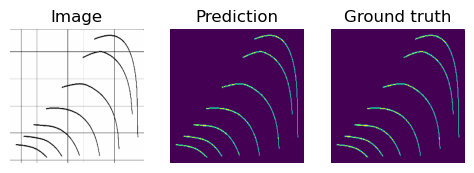

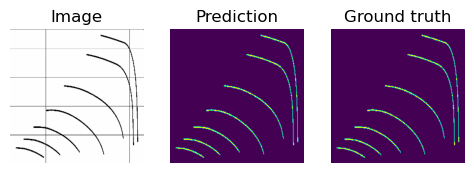

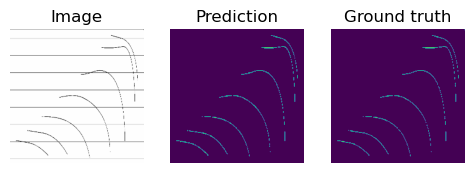

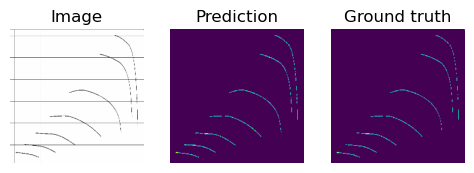

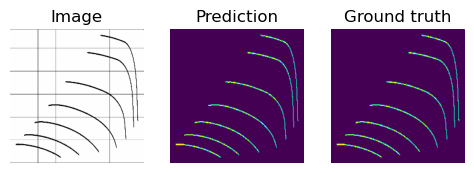

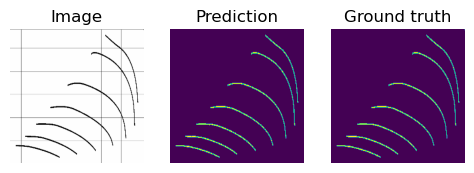

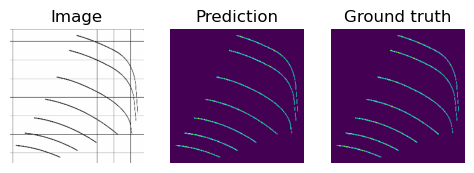

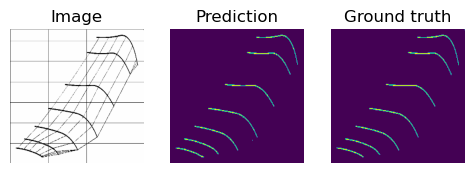

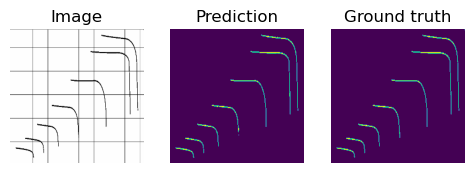

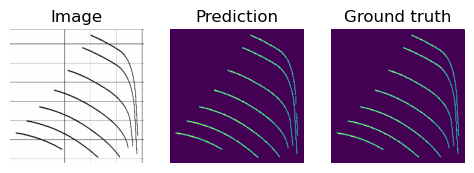

In [89]:
preds = model.predict(X)

rows = 1
columns = 5

for img, pred, mask in zip(X[:10], preds[0:10], y[0:10]):
    
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    
    fig.add_subplot(rows, columns, 2)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0 
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask, interpolation=None)
    plt.axis('off')
    plt.title("Ground truth")

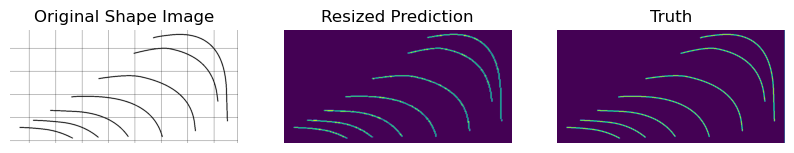

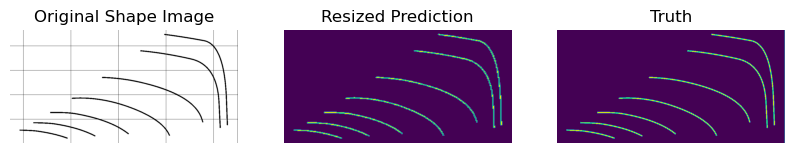

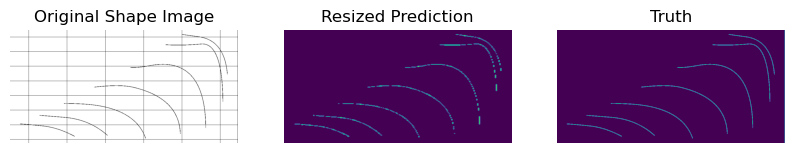

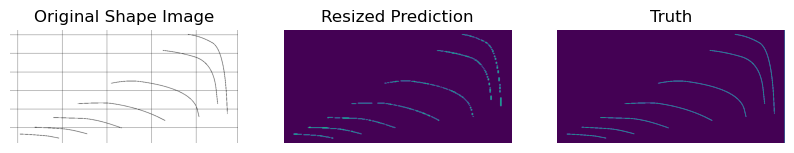

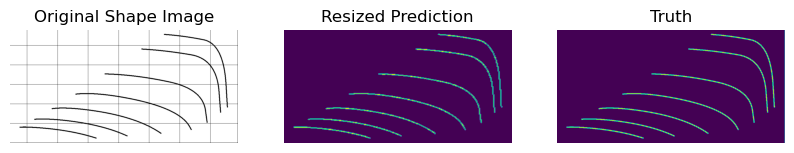

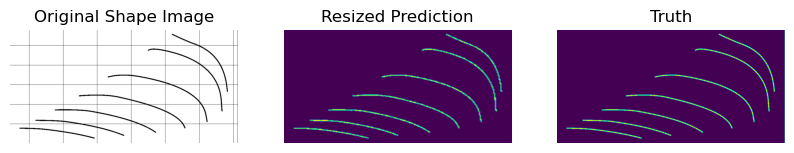

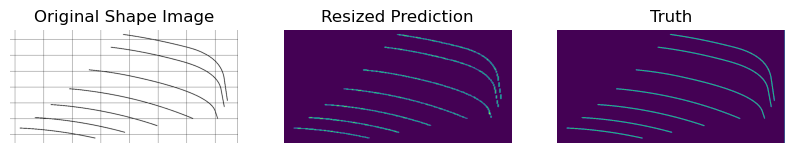

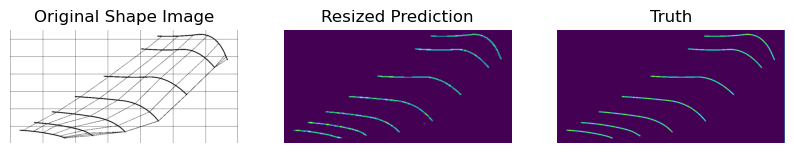

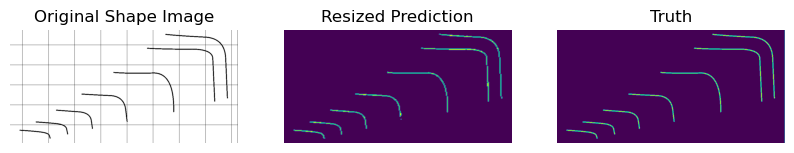

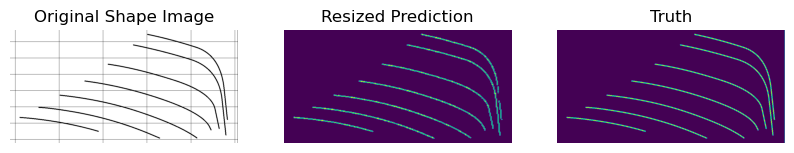

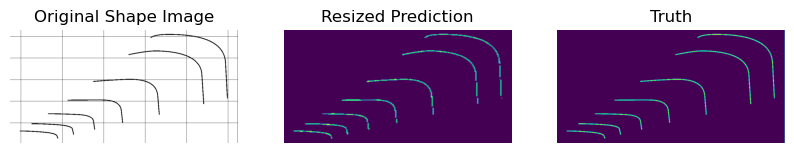

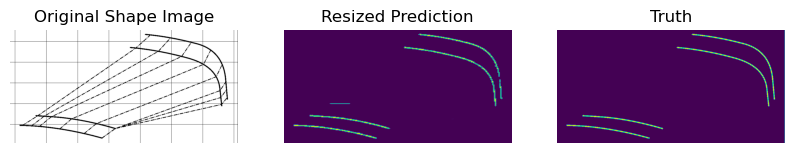

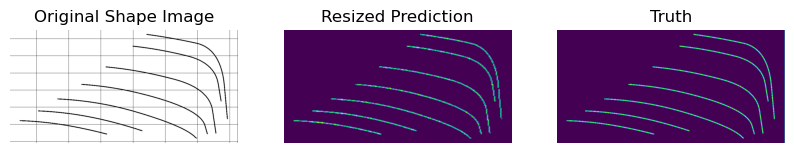

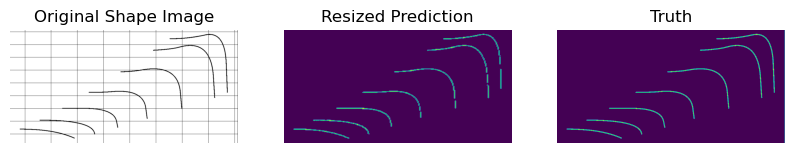

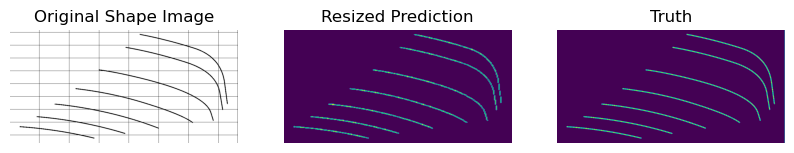

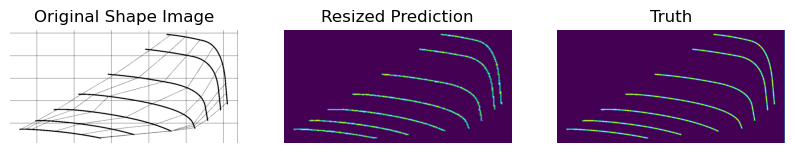

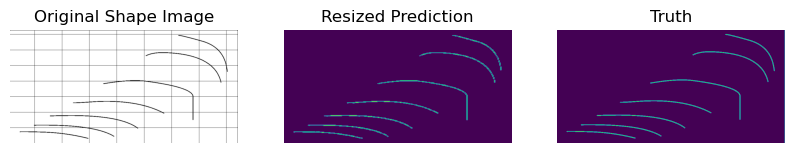

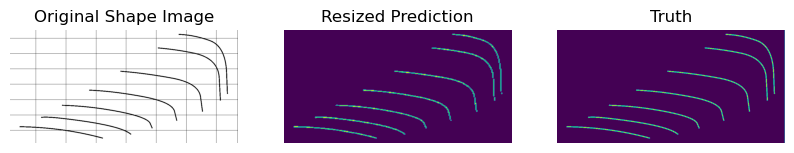

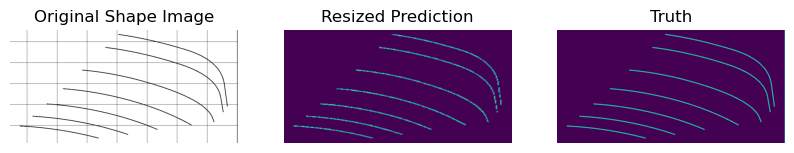

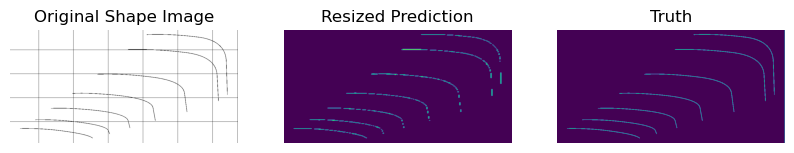

In [100]:
rows = 1
columns = 3

for pred, orig in zip(preds[:20], X_test[:20]):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    orig_path = os.path.join(IMG_DIR, orig)
    orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
    plt.imshow(orig_img)
    plt.axis('off')
    plt.title("Original Shape Image")

    fig.add_subplot(rows, columns, 2)
    #pred[pred >= 0.5] = 1
    #pred[pred < 0.5] = 0 
    pred = cv2.resize(pred, (orig_img.shape[:2][1],orig_img.shape[:2][0]))
    plt.imshow(pred)
    plt.axis('off')
    plt.title("Resized Prediction")
    
    fig.add_subplot(rows, columns, 3)
    truth_path = os.path.join(MASK_DIR, orig)
    truth = cv2.cvtColor(cv2.imread(truth_path), cv2.COLOR_BGR2GRAY)
    truth[truth==0]=1
    truth[truth!=1]=0
    plt.imshow(truth)
    plt.axis('off')
    plt.title("Truth")